In [26]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SequentialFeatureSelector, RFECV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import os

In [27]:
df = pd.read_csv('../data/preprocessed/reviewFeatures.csv')

Global seed number

In [28]:
seed = 101

60-20-20 data split.

In [29]:
def train_test_valid_split(df, targets):
    y = df[targets]
    X = df.drop(targets, axis=1)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=101, shuffle=True, stratify=y)

    # 25% of 0.8 is 0.2 
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=seed, stratify=y_train)     

    return X_train, X_test, X_val, y_train, y_test, y_val

Scaler for the dataset. Generally not required for random forest.

In [30]:
def rf_scaler(X_train, X_val, X_test):
    scaler = StandardScaler()
    X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
    X_val_scaled = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)    

    return X_train_scaled, X_val_scaled, X_test_scaled

Training function for fitting the model. StratifiedKFold used to satisfy 5-fold cross validation

In [31]:
def rf_classifier(X_train, y_train, grid_search=True):

    if(grid_search):
        model = RandomForestClassifier(random_state=seed)

        #5-Fold
        cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    

        #RF params
        param_grid = {
        'n_estimators': [100, 200, 500],
        'max_depth': [3, 4, 6],
        'max_features': ['sqrt', None, 4],
        'min_samples_split': [2, 4],
        'min_samples_leaf': [3, 5, 8],
        'class_weight': ['balanced'],
        'bootstrap': [True]
        }
        grid_search = GridSearchCV(
            estimator=model, 
            param_grid=param_grid, 
            cv=cv_strategy, 
            scoring='f1', 
            n_jobs=-1 
        )

        grid_search.fit(X_train, y_train)

        model = grid_search.best_estimator_
        
    else:
        model = RandomForestClassifier(
        n_estimators=200,
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=10,
        max_features='sqrt',
        class_weight='balanced',
        bootstrap=True,
        random_state=seed,
        n_jobs=-1
        )

        # Fit the model directly
        model.fit(X_train, y_train)


    # Given importances by random forest model
    importances = pd.Series(model.feature_importances_, index=X_train.columns)
    print("\n--- Feature Importance ---")
    print(importances.sort_values(ascending=False))
    if(grid_search):
        print(f"Best Parameters: {grid_search.best_params_}")
        print(f"Best Cross-Val F1 Score: {grid_search.best_score_:.4f}")

    
    return model

Evaluate on test set

In [32]:
def rf_predictions(model, X_test):

    y_pred = model.predict(X_test)

    return y_pred

To concat train and validation for k-fold

In [33]:
def concat_train_valid(X_train, y_train, X_val, y_val):
  X_train = pd.concat([X_train, X_val])
  y_train = pd.concat([y_train, y_val])

  return X_train, y_train

In [34]:
''' For manual feature selection '''
# def feat_select(X_train):
#     cols_to_drop = ["NPV", "NTP", "TPR"]

#     #Verify column names
#     existing_drops = [c for c in cols_to_drop if c in X_train.columns]
    
#     selected_features = X_train.drop(columns=existing_drops).columns.tolist()
    
#     print(f'Features dropped: {cols_to_drop}')
#     return selected_features

''' RFECV - recursive feature elimnination, with corss validation'''
def feat_select(X_train, y_train):
    rf = RandomForestClassifier(n_estimators=100, random_state=seed, n_jobs=-1)


    selector = RFECV(
        estimator=rf,
        step=1,
        cv=StratifiedKFold(5),
        scoring='f1',
        min_features_to_select=3,
        n_jobs=-1
    )

    selector = selector.fit(X_train, y_train)

    selected_features = X_train.columns[selector.support_].tolist()
    
    print(f"Selected Features: {selected_features}")
        

    return selected_features

In [35]:
def save_model(model, fs=False):
    
    if(fs):
        model_fp = os.path.join("../models", "best_rf_model_no_fs.joblib")
    else:
        model_fp = os.path.join("../models", "best_rf_model_fs.joblib")

    joblib.dump(model, model_fp)

    print(f"Saved best Random Forest Classifer to {model_fp}")

    return model   

Main function for performing classification

In [36]:
def rf_classification(df, grid_search=True, feature_selection=False, param_grid=None):
    #Split dataset
    X_train, X_test, X_val, y_train, y_test, y_val = train_test_valid_split(df, 'Real=1/Fake=0')

     # IF perfoming grid search, need train + val for k-fold
    if(grid_search):
        X_train, y_train = concat_train_valid(X_train, y_train, X_val, y_val)
        
    #Scale data (not really necessary for RF)
    X_train, X_val, X_test = rf_scaler(X_train=X_train, X_val=X_val, X_test=X_test)

    if feature_selection:
        selected_cols = feat_select(X_train, y_train)
        X_train = X_train[selected_cols]
        X_val = X_val[selected_cols]
        X_test = X_test[selected_cols]
    
   

    model = rf_classifier(X_train=X_train, y_train=y_train)

    if feature_selection:
        save_model(model, fs=True)
    else:
        save_model(model, fs=False)

    # Evaluate on train set
    y_train_pred = rf_predictions(model, X_test=X_train)
    train_acc = accuracy_score(y_train, y_train_pred)
    train_f1 = f1_score(y_train, y_train_pred)
    print("\n--- Training Performance ---")
    print(f"Accuracy: {train_acc:.4f}")
    print(f"F1 Score: {train_f1:.4f}")


    # Evaluate on test set
    y_test_pred = rf_predictions(model=model, X_test=X_test)

    accuracy = accuracy_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred)
    print("\n--- Final Test Performance ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")

    
    print("\nReport:")
    print(classification_report(y_test, y_test_pred))


    #Plot confusion matrix
    conf_matrix = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', 
                xticklabels=['Fake (0)', 'Real (1)'], 
                yticklabels=['Fake (0)', 'Real (1)'])
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    
    
    # Save the plot
    if feature_selection:
        plt.title(f'Random Forest Confusion Matrix with FS\nF1 Score: {f1:.4f}')
        plt.savefig('confusion_matrix_fs.png', bbox_inches='tight')
    else:
        plt.title(f'Random Forest Confusion Matrix w/o FS\nF1 Score: {f1:.4f}')
        plt.savefig('confusion_matrix.png', bbox_inches='tight')
    
    

Selected Features: ['AWL', 'ASL', 'NOW', 'NVB', 'NAJ', 'NST', 'CDV']

--- Feature Importance ---
NAJ    0.231826
NOW    0.192160
NST    0.154546
AWL    0.131231
NVB    0.125101
CDV    0.087247
ASL    0.077889
dtype: float64
Best Parameters: {'bootstrap': True, 'class_weight': 'balanced', 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 200}
Best Cross-Val F1 Score: 0.6512
Saved best Random Forest Classifer to ../models/best_rf_model_no_fs.joblib

--- Training Performance ---
Accuracy: 0.7452
F1 Score: 0.7104

--- Final Test Performance ---
Accuracy: 0.6923
F1 Score: 0.6522

Report:
              precision    recall  f1-score   support

           0       0.66      0.81      0.72        26
           1       0.75      0.58      0.65        26

    accuracy                           0.69        52
   macro avg       0.70      0.69      0.69        52
weighted avg       0.70      0.69      0.69        52



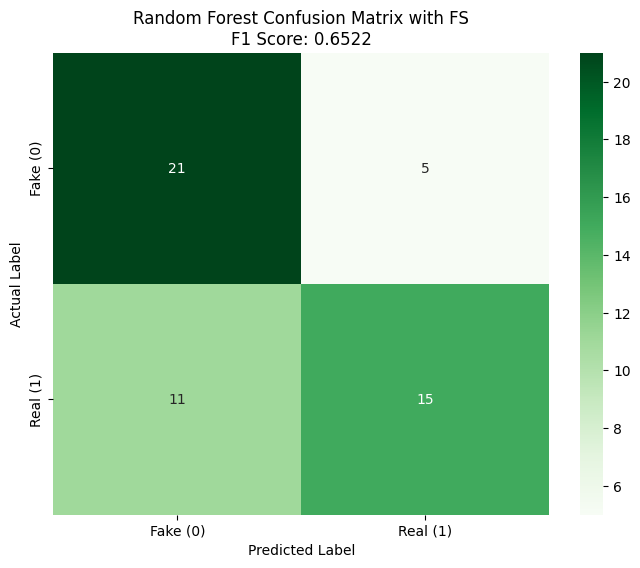

In [37]:
rf_classification(df, feature_selection=True, grid_search=True)


--- Feature Importance ---
NAJ    0.235725
NOW    0.182351
NST    0.117877
AWL    0.094755
CDV    0.094087
NVB    0.092256
ASL    0.086325
TPR    0.044400
NTP    0.042572
NPV    0.009653
dtype: float64
Best Parameters: {'bootstrap': True, 'class_weight': 'balanced', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 500}
Best Cross-Val F1 Score: 0.6534
Saved best Random Forest Classifer to ../models/best_rf_model_fs.joblib

--- Training Performance ---
Accuracy: 0.7981
F1 Score: 0.7766

--- Final Test Performance ---
Accuracy: 0.6731
F1 Score: 0.6222

Report:
              precision    recall  f1-score   support

           0       0.64      0.81      0.71        26
           1       0.74      0.54      0.62        26

    accuracy                           0.67        52
   macro avg       0.69      0.67      0.67        52
weighted avg       0.69      0.67      0.67        52



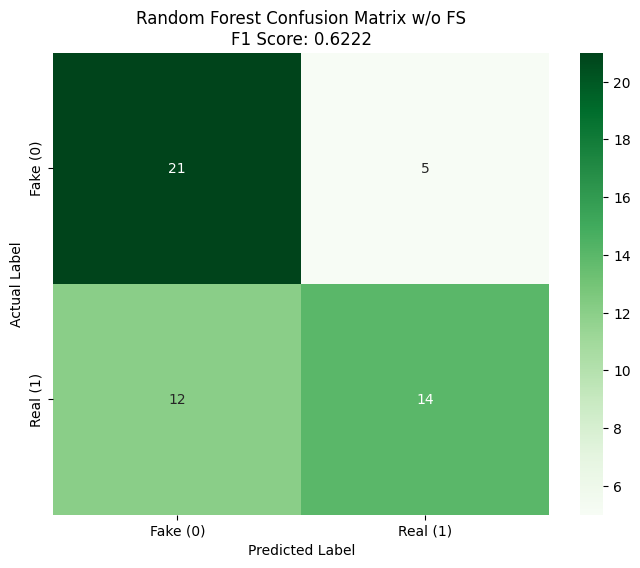

In [38]:
rf_classification(df, feature_selection=False, grid_search=True)